Работу выполнил Данил Исламов (Stepik ID: 274397404)

# Spoken Language Processing
В этом задании предлагается обучить классификатор возраста по голосу (пример с тем, как это можно сделать для пола см. в семинаре).

Подумайте, как лучше предсказывать возраст (может быть, разбить на группы?) и какой лосс использовать.

P.S. не забудьте, что если вы работаете в Colab, то вы можете поменять среду выполнения на GPU/TPU!

Вопросы по заданию/материалам: @Nestyme

In [ ]:
!pip3 install timit-utils==0.9.0
!pip3 install torchaudio
!wget https://ndownloader.figshare.com/files/10256148 
!unzip -q 10256148

In [ ]:
import timit_utils as tu
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils import class_weight

import IPython
from IPython.display import clear_output

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Задание 1
Загрузите данные для обучения. Для этого:
1. Скачайте датасет TIMIT (см. семинар)
2. Соберите пары "голос"  — "класс возраста" так же, как на семинаре собирались пары "голос"  — "пол". Аудиодорожки сконвертируйте в мел-спектрограммы при помощи `torchaudio` или `librosa`

P.S. вы можете использовать свою реализацию, а можете предложенную (см. следующие ячейки)

Будем использовать код с семинара с незначительными изменениями.

In [ ]:
class timit_dataloader:
    def __init__(self, data_path='data/lisa/data/timit/raw/TIMIT', train_mode=True):
        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)
        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        if train_mode:
            self.trainset = self.create_dataset('train')
            self.validset = self.create_dataset('valid')
        self.testset = self.create_dataset('test')

    def return_age(self, id):
        return self.id_age_dict[id]

    def return_data(self):
        return self.trainset, self.validset, self.testset

    def return_test(self):
        return self.testset

    def create_dataset(self, mode):
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            train_size = round(len(self.corpus.train.people) * 0.8)
            people = [self.corpus.train.person_by_index(i) for i in range(train_size)]
        elif mode == 'valid':
            train_size = round(len(self.corpus.train.people) * 0.8) 
            people = [self.corpus.train.person_by_index(i) for i in range(train_size, len(self.corpus.train.people))]
        elif mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(len(self.corpus.test.people))]
        spectrograms_and_targets = []
        for person in tqdm(people):
              try:
                  target = self.return_age(person.name)
                  for i in range(len(person.sentences)):
                      spectrograms_and_targets.append(
                          self.preprocess_sample(person.sentence_by_index(i).raw_audio, target))
              except:
                  print(person.name, target)

        X, y = map(np.stack, zip(*spectrograms_and_targets))
        X = X.transpose([0, 2, 1])  # [batch, channels, time] -> [batch, time, channels]
        return X, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    @staticmethod
    def clasterize_by_age(age):
        if age < 25:
            return 0
        if 25 <= age < 40:
            return 1
        if age >= 40:
            return 2

    def preprocess_sample(self, amplitudes, target, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        target = self.clasterize_by_age(target)
        return self.spec_to_image(np.float32(spectrogram)), target

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return torch.tensor(spectrogram, dtype=torch.float).to(device, non_blocking=True)

In [ ]:
class dataloader:
    def __init__(self, spectrograms, targets, batch_size, device):
        self.data = list(zip(spectrograms, targets))
        self.batch_size = batch_size
        self.batches_count = int(np.ceil(len(self.data) / batch_size))
        self.device = device
    
    def next_batch(self):
        indices = np.random.randint(len(self.data), size=self.batch_size)

        input = [self.data[i] for i in indices]

        source = [line[0] for line in input]
        target = [line[1] for line in input]

        return self.torch_batch(source, target, self.device)

    @staticmethod
    def torch_batch(source, target, device):
        return tuple(
            [torch.tensor(source, dtype=torch.float).to(device, non_blocking=True),
             torch.tensor(target, dtype=torch.long).to(device, non_blocking=True)]
        )

    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.random.shuffle(np.arange(len(self.data)))
        
        for i in range(0, len(self.data), self.batch_size):
            input = [self.data[i:i+self.batch_size]][0]
            
            source = [line[0] for line in input]
            target = [line[1] for line in input]

            yield self.torch_batch(source, target, self.device)

In [ ]:
_timit_dataloader = timit_dataloader()
train, valid, test = _timit_dataloader.return_data()

BATCH_SIZE = 64

trainset = dataloader(*train, BATCH_SIZE, device)
validset = dataloader(*valid, BATCH_SIZE, device)
testset = dataloader(*test, BATCH_SIZE, device)

Посмотрим, как выглядит мел-спектрограмма первой записи.

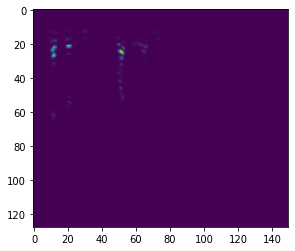

In [ ]:
plt.imshow(train[0][0].transpose())
plt.show()

Судя по всему, матрица изображения сильно разрежена, т.к. на картинке видны только очень небольшие цветные пятна. Посмотрим, какова доля ненулевых элементов в ней.

In [ ]:
np.count_nonzero(train[0][0]) / np.prod(train[0][0].shape)

0.03536458333333333

Получается, что в матрице изображения примерно 3.5% ненулевых значений. Посчитаем этот же показатель для нескольких первых картинок.

In [ ]:
for i in range(2, 5):
    print(np.count_nonzero(train[0][i]) / np.prod(train[0][i].shape))

0.022291666666666668
0.020677083333333332
0.053385416666666664


Видно, что малое количество ненулевых значений свойственно по крайней мере первым четырём изображениям, а потому вполне возможно, что это верно и для остальных изображений. Будем иметь в виду данный факт.

## Задание 2
1. Обучите свой классификатор категории возраста
2. Попробуйте улучшить результат. Можно попробовать усложнить сетку, подвигать границы категорий, поискать новые данные, что угодно, кроме учиться на тесте :)
3. Какой подход оказался самым эффективным? Как думаете, почему?
4. Как считаете, где можно было бы применить такой классификатор в качестве вспомогательной задачи?


### Вспомогательные функции

In [ ]:
# Функция, использующая для обучения заданное количество случайно выбираемых батчей
def random_batch_training(model, train_data, valid_data, criterion, optimizer,
                          num_batches, patience):
    
    best_loss = float('inf')
    cnt = 0

    train_history = []
    valid_history = []
    accuracy_history = []
    f1_history = []

    for i in tqdm(range(num_batches)):
        model.train()

        optimizer.zero_grad()

        inp, targ = train_data.next_batch()
        outp = model(inp)
        loss = criterion(outp, targ)

        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            clear_output()
            
            train_history.append(loss.item())
            
            model.eval()

            with torch.no_grad():

                inp, targ = valid_data.next_batch()
                outp = model(inp)
                valid_loss = criterion(outp, targ)
                valid_history.append(valid_loss.item())

                outp, targ = outp.cpu().detach().numpy(), targ.cpu().detach().numpy()
                outp = [np.argmax(tmp) for tmp in outp]            
                accuracy = accuracy_score(outp, targ)
                f1 = f1_score(outp, targ, average='macro')
                accuracy_history.append(accuracy)
                f1_history.append(f1)
                
                print(f'accuracy_score:{accuracy}')
                print(f'f1_score:{f1}')
                print("i {}, valid {}".format(i, valid_loss.item()))
                print("_________")

                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
                ax[0].plot(train_history, label='train_history')
                ax[0].plot(valid_history, label='valid_history')
                ax[1].plot(accuracy_history, label='accuracy_history')
                ax[1].plot(f1_history, label='f1_history')
                ax[0].legend()
                ax[1].legend()
                plt.show()

        if i % 50 == 0 and best_loss > valid_loss.item():
            best_loss = valid_loss.item()
            torch.save(model.state_dict(), 'best_model_by_rand_batch.pt')
            cnt = 0
        else:
            cnt += 1

        if cnt > patience:
            break

    print('training finished')


In [ ]:
# Функция, реализующая классическое обучение по эпохам
def epoch_training(model, train_data, valid_data, criterion, optimizer, 
                   num_epochs):
    
    train_history = []
    valid_history = []
    acc_history = []
    f1_history = []

    for e in range(num_epochs):
               
        model.train()
        train_loss = 0
        history = []
        
        for batch in tqdm(train_data):

            optimizer.zero_grad()

            inp, targ = batch

            outp = model(inp)

            loss = criterion(outp, targ)
            train_loss += loss.item()
            history.append(loss.item())
            
            loss.backward()
            optimizer.step()

        train_history.append(train_loss / len(train_data))  

        best_valid_loss = float('inf')
        valid_loss = 0
        valid_acc = 0
        valid_f1 = 0
        model.eval()
        
        with torch.no_grad():
            
            for batch in valid_data:
                
                inp, targ = batch

                outp = model(inp)

                loss = criterion(outp, targ)
                valid_loss += loss.item()

                if valid_loss < best_valid_loss:
                    best_valid_loss = valid_loss
                    torch.save(model.state_dict(), 'best_model_by_epoch.pt')
                
                outp, targ = outp.cpu().detach().numpy(), targ.cpu().detach().numpy()
                outp = [np.argmax(tmp) for tmp in outp]
                valid_acc += accuracy_score(outp, targ)
                valid_f1 += f1_score(outp, targ, average='macro')

        acc_history.append(valid_acc / len(valid_data))       
        f1_history.append(valid_f1 / len(valid_data))
        valid_history.append(valid_loss / len(valid_data))

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    
        clear_output(True)
        ax[0].plot(history, label='train loss')
        ax[0].set_xlabel('Batch')
        ax[0].set_title('Train loss')
        ax[0].legend()

        ax[1].plot(train_history, label='general train history')        
        ax[1].plot(valid_history, label='general valid history')
        ax[1].set_xlabel('Epoch')
        ax[1].legend()

        ax[2].plot(acc_history, label='valid accuracy history')
        ax[2].plot(f1_history, label='valid f1 history')
        ax[2].set_xlabel('Epoch')
        ax[2].legend()

        plt.show()

        print(f"Train Loss: {train_loss / len(train_data)},"
              f"Valid Loss: {valid_loss / len(valid_data)},"
              f"Valid Acc: {valid_acc / len(valid_data)}")

In [ ]:
# Функция, вычисляющая показатели модели на тестовой выборке
def testing(model, test_data, best_model_path=None):
    if best_model_path:
        model.load_state_dict(torch.load(best_model_path))
    
    model.eval()
    accuracy = 0
    f1_result = 0
    
    for batch in tqdm(test_data):
        with torch.no_grad():
            inp, targ = batch
            outp = model(inp)
            outp, targ = outp.cpu().detach().numpy(), targ.cpu().detach().numpy()
            outp = [np.argmax(tmp) for tmp in outp]
            acc = accuracy_score(outp, targ)
            f1 = f1_score(outp, targ, average='macro')
            accuracy += acc / len(test_data)
            f1_result += f1 / len(test_data)
            
    return {'accuracy': accuracy, 'f1_score': f1_result}

In [ ]:
# Функция, делающая предсказания по переданной аудиозаписи формата .wav
def predict(wavfile):
    waveform, _ = librosa.load(wavfile, sr=16000)

    inp = _timit_dataloader.preprocess_sample(waveform)
    with torch.no_grad():
        outp = model(torch.tensor(inp, dtype=torch.float).to(device))
        outp = outp.cpu().detach().numpy()
    print(outp)
    outp = np.argmax(outp)
    return outp

### Baseline

Для начала обучим относительно простую модель на выборке с заданными по умолчанию границами классов, чтобы найти некоторую точку отсчёта для измерения качества. В качестве показателей качества будем использовать метрики accuracy и f1-score; значение f1-score на всём датасете будем считать как простое среднее f1-score всех классов. 

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5)):
        super(BaseModel, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(1, 128, [window_size, 128], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])

        self.fc = nn.Linear(128 * len(window_sizes), 3)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)  # Add channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)
        x = x.view(x.size(0), -1) 
        logits = self.fc(x)
        return logits

accuracy_score:0.640625
f1_score:0.3006535947712418
i 700, valid 0.997870922088623
_________


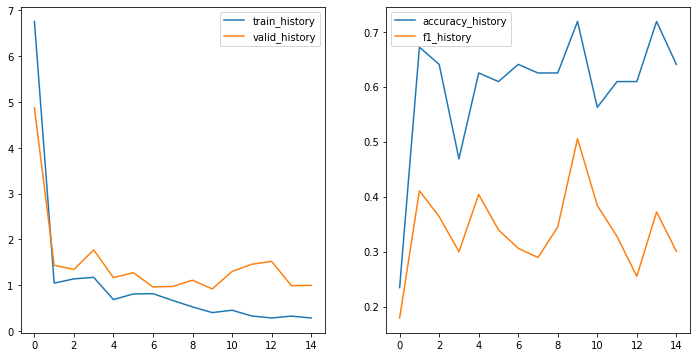

training finished


In [ ]:
model = BaseModel().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-5, lr=1e-4)

patience = 250
num_batches = 1000

random_batch_training(model, trainset, validset, criterion, optimizer, num_batches, patience)

In [ ]:
testing(model, testset, best_model_path='best_model_by_rand_batch.pt')

{'accuracy': 0.6151620370370371, 'f1_score': 0.3273938129363106}

По графикам изменения accuracy и f1-score при обучении, как и по показателям модели на тестовом датасете, видно, что f1-score получается почти в 2 раза ниже, чем accuracy. Возможно, это связано с дисбалансом классов. Проверим данное предположение.

In [ ]:
for i in range(3):
    print(np.count_nonzero(train[1] == i) / len(train[1]))

0.16486486486486487
0.7081081081081081
0.12702702702702703


Действительно, видно, что объектов класса 1 (т.е. записей голосов людей в возрасте от 25 до 40 лет) оказалось подавляющее большинство — чуть больше 70%. С учётом данного факта, обучим модель ещё раз, применив в этот раз веса для подсчёта лосса.

accuracy_score:0.59375
f1_score:0.3681630546955625
i 400, valid 1.9274842739105225
_________


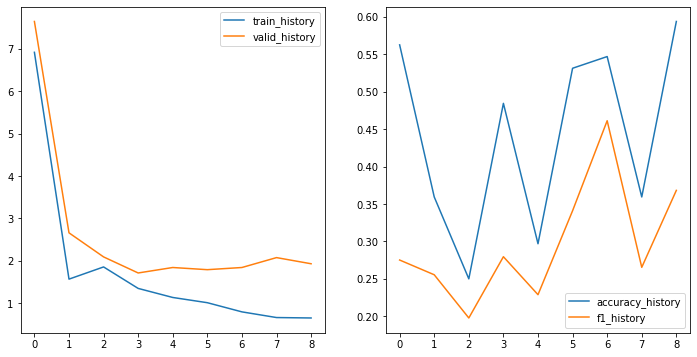

training finished


In [ ]:
model = BaseModel().to(device)

weight = class_weight.compute_class_weight('balanced', np.unique(train[1]), train[1])
weight = weight / sum(weight)
weight = torch.tensor(weight, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight)

optimizer = Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-5, lr=1e-4)

patience = 250
num_batches = 1000

random_batch_training(model, trainset, validset, criterion, optimizer, num_batches, patience)

In [ ]:
testing(model, testset, best_model_path='best_model_by_rand_batch.pt')

{'accuracy': 0.47395833333333326, 'f1_score': 0.3151839576916548}

Заметно, что теперь значения f1-score и accuracy получились более близкими. Однако, так получилось из-за снижения accuracy, f1-score же почти не изменился, т.е., возможно, модель стала реже предсказывать доминирующий класс, однако, на её качество в целом это не очень повлияло.

### Усложнённая модель

Попробуем сделать модель более глубокой — возможно, это позволит улучшить качество предсказаний.

Отмечу, что в процессе работы над заданием тестировались различные варианты архитектуры, в том числе и более простые по сравнению с базовой моделью. Здесь же приведу только модель, показавшую лучшие результаты.

In [ ]:
class Model2(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5)):
        super(Model2, self).__init__()

        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1, 128, [window_size, 128], padding=(window_size - 1, 0)),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Dropout2d(0.3))
            for window_size in window_sizes
        ])

        self.fc = nn.Sequential(nn.Linear(128 * len(window_sizes), 128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(),
                                nn.Dropout(0.2),
                                nn.Linear(128, 3))

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = conv(x)
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits

Сначала, так же, как и базовую модель, обучим её без весов в лоссе, а затем с весами.

accuracy_score:0.765625
f1_score:0.36236236236236236
i 550, valid 0.8068637251853943
_________


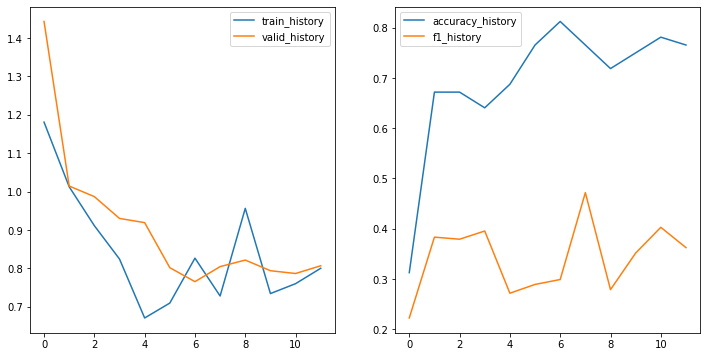

training finished


In [ ]:
model = Model2().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-5, lr=1e-4)

patience = 250
num_batches = 1000

random_batch_training(model, trainset, validset, criterion, optimizer, num_batches, patience)

In [ ]:
testing(model, testset, best_model_path='best_model_by_rand_batch.pt')

{'accuracy': 0.7222222222222221, 'f1_score': 0.38623775596527077}

По сравнению с результатами обученной без весов базовой модели, данная модель показала более высокие accuracy и f1-score, значения которых оказались выше примерно на 0.1 и на 0.05 соответственно.

accuracy_score:0.421875
f1_score:0.3967090257412838
i 550, valid 1.1122093200683594
_________


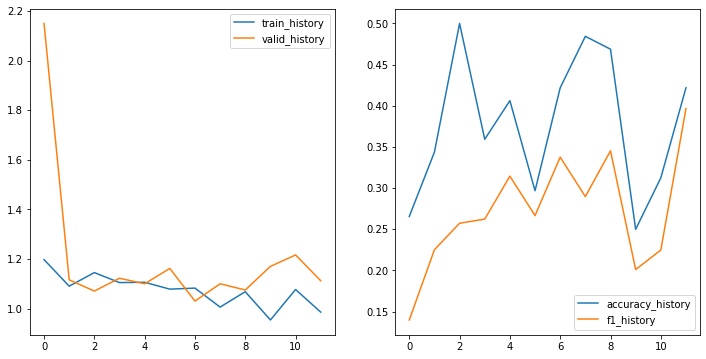

training finished


In [ ]:
model = Model2().to(device)

criterion = nn.CrossEntropyLoss(weight)

optimizer = Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-5, lr=1e-4)

patience = 250
num_batches = 1000

random_batch_training(model, trainset, validset, criterion, optimizer, num_batches, patience)

In [ ]:
testing(model, testset, best_model_path='best_model_by_rand_batch.pt')

{'accuracy': 0.45428240740740733, 'f1_score': 0.3083728645527009}

При обучении же с весами результаты оказались даже немного ниже, чем у базовой модели. Тем не менее, данные показатели не детерминированы и получаются разными даже при повторной инициализации и тренировке одной и той же модели. В силу этого, думаю, что снижение accuracy и f1-score не является значимым. 

Несмотря на то, что качество данной модели оказалось не хуже (а при обучении без весов — заметно лучше), чем у базовой модели, результаты, если ориентироваться в основном на f1-score, по-прежнему очень низкие. Возможно, дело в неудачном разбиении выборки на классы. Попробуем "пошевелить" границы классов — возможно, это приведёт к улучшению показателей.

### Новые границы классов

#### С сохранением разделения по возрастным группам

Для начала попытаемся изменить пороги классов так, чтобы при этом сохранялось какое-то логичное разделение на возрастные группы.

Как и в случае с архитектурой модели, в процессе работы над заданием было опробовано несколько комбинаций порогов классов, однако здесь продемонстрирован только один вариант — в качестве показательного примера его будет достаточно.

In [ ]:
class timit_dataloader:
    def __init__(self, data_path='data/lisa/data/timit/raw/TIMIT', train_mode=True):
        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)
        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        if train_mode:
            self.trainset = self.create_dataset('train')
            self.validset = self.create_dataset('valid')
        self.testset = self.create_dataset('test')

    def return_age(self, id):
        return self.id_age_dict[id]

    def return_data(self):
        return self.trainset, self.validset, self.testset

    def return_test(self):
        return self.testset

    def create_dataset(self, mode):
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            train_size = round(len(self.corpus.train.people) * 0.8)
            people = [self.corpus.train.person_by_index(i) for i in range(train_size)]
        elif mode == 'valid':
            train_size = round(len(self.corpus.train.people) * 0.8) 
            people = [self.corpus.train.person_by_index(i) for i in range(train_size, len(self.corpus.train.people))]
        elif mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(len(self.corpus.test.people))]
        spectrograms_and_targets = []
        for person in tqdm(people):
              try:
                  target = self.return_age(person.name)
                  for i in range(len(person.sentences)):
                      spectrograms_and_targets.append(
                          self.preprocess_sample(person.sentence_by_index(i).raw_audio, target))
              except:
                  print(person.name, target)

        X, y = map(np.stack, zip(*spectrograms_and_targets))
        X = X.transpose([0, 2, 1])  # [batch, channels, time] -> [batch, time, channels]
        return X, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    @staticmethod
    def clasterize_by_age(age):
        if age < 30:
            return 0
        if 30 <= age < 50:
            return 1
        if age >= 50:
            return 2

    def preprocess_sample(self, amplitudes, target, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        target = self.clasterize_by_age(target)
        return self.spec_to_image(np.float32(spectrogram)), target

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return torch.tensor(spectrogram, dtype=torch.float).to(device, non_blocking=True)

In [ ]:
_timit_dataloader = timit_dataloader()
train, valid, test = _timit_dataloader.return_data()

BATCH_SIZE = 64

trainset = dataloader(*train, BATCH_SIZE, device)
validset = dataloader(*valid, BATCH_SIZE, device)
testset = dataloader(*test, BATCH_SIZE, device)

Посмотрим на новые пропорции классов:

In [ ]:
for i in range(3):
    print(np.count_nonzero(train[1] == i) / len(train[1]))

0.5675675675675675
0.4027027027027027
0.02972972972972973


Обучим модель (начиная отсюда использоваться будет только Model2).

accuracy_score:0.484375
f1_score:0.32621082621082614
i 850, valid 0.8869975805282593
_________


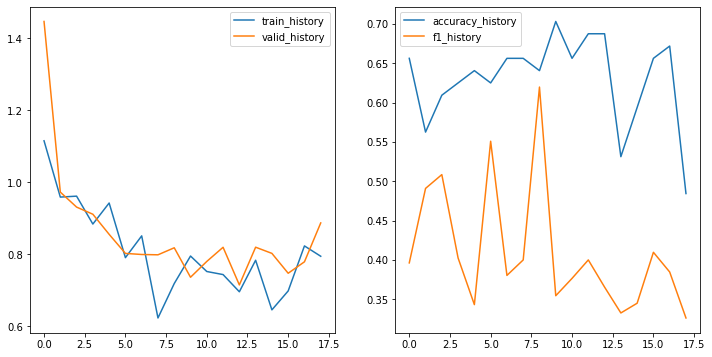

training finished


In [ ]:
model = Model2().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-5, lr=1e-4)

patience = 250
num_batches = 1000

random_batch_training(model, trainset, validset, criterion, optimizer, num_batches, patience)

In [ ]:
testing(model, testset, best_model_path='best_model_by_rand_batch.pt')

{'accuracy': 0.505787037037037, 'f1_score': 0.4197508886894229}

При данном разбиении на классы величина accuracy заметно упала, хотя f1-score осталась примерно на том же уровне. Кроме того, можно увидеть, что accuracy оказалась близка к доле доминирующего класса, что наблюдалось и при предыдущем разбиении.

accuracy_score:0.4375
f1_score:0.3196078431372549
i 800, valid 1.2811659574508667
_________


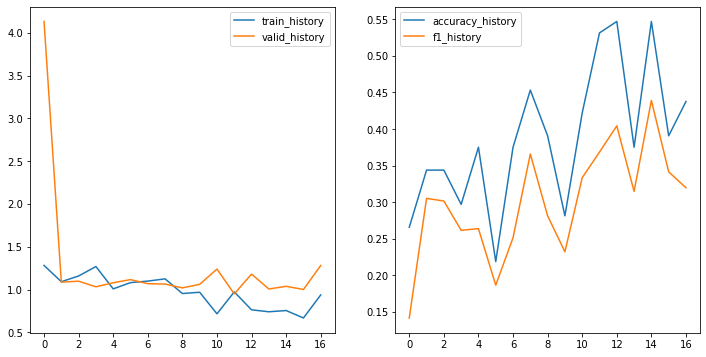

training finished


In [ ]:
model = Model2().to(device)

weight = class_weight.compute_class_weight('balanced', np.unique(train[1]), train[1])
weight = weight / sum(weight)
weight = torch.tensor(weight, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight)

optimizer = Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-5, lr=1e-4)

patience = 250
num_batches = 1000

random_batch_training(model, trainset, validset, criterion, optimizer, num_batches, patience)

In [ ]:
testing(model, testset, best_model_path='best_model_by_rand_batch.pt')

{'accuracy': 0.40624999999999994, 'f1_score': 0.3148388666802953}

Результаты обучения с весами получаются вновь того же порядка, что и раньше, хотя accuracy и оказалась несколько ниже, чем при обучении с весами на прошлых классах.

#### С равномерным распределением классов

Теперь попробуем разбить данные на 3 примерно равных по величине класса. Хотя такое разбиение вряд ли можно как-то логично интерпретировать (с учётом того, что возраст большинства людей, записи чьих голосов присутствуют в датасете, был в районе 25-35 лет), всё же посмотрим на результаты.

In [ ]:
class timit_dataloader:
    def __init__(self, data_path='data/lisa/data/timit/raw/TIMIT', train_mode=True):
        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)
        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        if train_mode:
            self.trainset = self.create_dataset('train')
            self.validset = self.create_dataset('valid')
        self.testset = self.create_dataset('test')

    def return_age(self, id):
        return self.id_age_dict[id]

    def return_data(self):
        return self.trainset, self.validset, self.testset

    def return_test(self):
        return self.testset

    def create_dataset(self, mode):
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            train_size = round(len(self.corpus.train.people) * 0.8)
            people = [self.corpus.train.person_by_index(i) for i in range(train_size)]
        elif mode == 'valid':
            train_size = round(len(self.corpus.train.people) * 0.8) 
            people = [self.corpus.train.person_by_index(i) for i in range(train_size, len(self.corpus.train.people))]
        elif mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(len(self.corpus.test.people))]
        spectrograms_and_targets = []
        for person in tqdm(people):
              try:
                  target = self.return_age(person.name)
                  for i in range(len(person.sentences)):
                      spectrograms_and_targets.append(
                          self.preprocess_sample(person.sentence_by_index(i).raw_audio, target))
              except:
                  print(person.name, target)

        X, y = map(np.stack, zip(*spectrograms_and_targets))
        X = X.transpose([0, 2, 1])  # [batch, channels, time] -> [batch, time, channels]
        return X, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    @staticmethod
    def clasterize_by_age(age):
        if age < 27:
            return 0
        if 27 <= age < 33:
            return 1
        if age >= 33:
            return 2

    def preprocess_sample(self, amplitudes, target, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        target = self.clasterize_by_age(target)
        return self.spec_to_image(np.float32(spectrogram)), target

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return torch.tensor(spectrogram, dtype=torch.float).to(device, non_blocking=True)

In [ ]:
_timit_dataloader = timit_dataloader()
train, valid, test = _timit_dataloader.return_data()

BATCH_SIZE = 64

trainset = dataloader(*train, BATCH_SIZE, device)
validset = dataloader(*valid, BATCH_SIZE, device)
testset = dataloader(*test, BATCH_SIZE, device)

In [ ]:
for i in range(3):
    print(np.count_nonzero(train[1] == i) / len(train[1]))

0.36486486486486486
0.35135135135135137
0.28378378378378377


Доли классов получились примерно одинаковыми, из-за чего веса при обучении вряд ли принесут какой-то значительный вклад. Будем обучать модель без них.

accuracy_score:0.375
f1_score:0.36874416005169725
i 600, valid 1.0971788167953491
_________


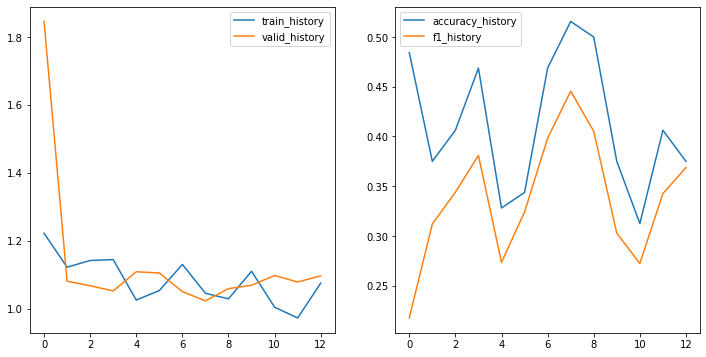

training finished


In [ ]:
model = Model2().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-5, lr=1e-4)

patience = 250
num_batches = 1000

random_batch_training(model, trainset, validset, criterion, optimizer, num_batches, patience)

In [ ]:
testing(model, testset, best_model_path='best_model_by_rand_batch.pt')

{'accuracy': 0.4079861111111111, 'f1_score': 0.35212726922662924}

Результаты получились примерно такими же, как и при обучении с весами на других распределениях классов.

### 2 класса

Возможно, модели просто не хватает данных, чтобы выучить какие-либо закономерности или разделение на 3 класса получается избыточным. Попробуем разделить данные на 2 класса и посмотрим, улучшит ли это результат. Для сравнения будем использовать 2 варианта разбиения.

#### 1-й вариант разбиения

In [ ]:
class timit_dataloader:
    def __init__(self, data_path='data/lisa/data/timit/raw/TIMIT', train_mode=True):
        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)
        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        if train_mode:
            self.trainset = self.create_dataset('train')
            self.validset = self.create_dataset('valid')
        self.testset = self.create_dataset('test')

    def return_age(self, id):
        return self.id_age_dict[id]

    def return_data(self):
        return self.trainset, self.validset, self.testset

    def return_test(self):
        return self.testset

    def create_dataset(self, mode):
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            train_size = round(len(self.corpus.train.people) * 0.8)
            people = [self.corpus.train.person_by_index(i) for i in range(train_size)]
        elif mode == 'valid':
            train_size = round(len(self.corpus.train.people) * 0.8) 
            people = [self.corpus.train.person_by_index(i) for i in range(train_size, len(self.corpus.train.people))]
        elif mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(len(self.corpus.test.people))]
        spectrograms_and_targets = []
        for person in tqdm(people):
              try:
                  target = self.return_age(person.name)
                  for i in range(len(person.sentences)):
                      spectrograms_and_targets.append(
                          self.preprocess_sample(person.sentence_by_index(i).raw_audio, target))
              except:
                  print(person.name, target)

        X, y = map(np.stack, zip(*spectrograms_and_targets))
        X = X.transpose([0, 2, 1])  # [batch, channels, time] -> [batch, time, channels]
        return X, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    @staticmethod
    def clasterize_by_age(age):
        if age < 30:
            return 0
        else:
            return 1

    def preprocess_sample(self, amplitudes, target, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        target = self.clasterize_by_age(target)
        return self.spec_to_image(np.float32(spectrogram)), target

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return torch.tensor(spectrogram, dtype=torch.float).to(device, non_blocking=True)

In [ ]:
_timit_dataloader = timit_dataloader()
train, valid, test = _timit_dataloader.return_data()

BATCH_SIZE = 64

trainset = dataloader(*train, BATCH_SIZE, device)
validset = dataloader(*valid, BATCH_SIZE, device)
testset = dataloader(*test, BATCH_SIZE, device)

In [ ]:
for i in range(2):
    print(np.count_nonzero(train[1] == i) / len(train[1]))

0.5675675675675675
0.43243243243243246


Доли классов получились примерно одинаковыми, поэтому будем обучать модель без весов.

In [ ]:
# Меняем размерность выхода модели с 3 на 2
class Model2(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5)):
        super(Model2, self).__init__()

        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1, 128, [window_size, 128], padding=(window_size - 1, 0)),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Dropout2d(0.3))
            for window_size in window_sizes
        ])

        self.fc = nn.Sequential(nn.Linear(128 * len(window_sizes), 128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(),
                                nn.Dropout(0.2),
                                nn.Linear(128, 2))

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = conv(x)
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits

accuracy_score:0.609375
f1_score:0.6014943960149439
i 800, valid 0.6903060674667358
_________


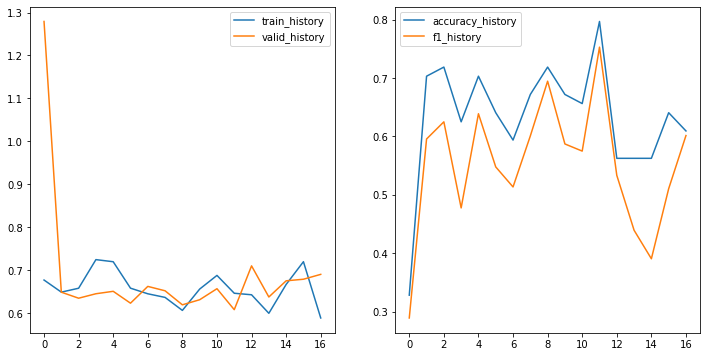

training finished


In [ ]:
model = Model2().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-5, lr=1e-4)

patience = 250
num_batches = 1000

random_batch_training(model, trainset, validset, criterion, optimizer, num_batches, patience)

In [ ]:
testing(model, testset, best_model_path='best_model_by_rand_batch.pt')

{'accuracy': 0.5503472222222222, 'f1_score': 0.4888172084987139}

По сравнению с моделью, предсказывающей 3 класса и обученной с использованием весов, величины accuracy и f1-score данной модели получились значительно выше. Однако, если брать в расчёт то, что теперь классов было всего 2, полученные результаты всё равно являются очень низкими.

#### 2-й вариант разбиения

In [ ]:
class timit_dataloader:
    def __init__(self, data_path='data/lisa/data/timit/raw/TIMIT', train_mode=True):
        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)
        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        if train_mode:
            self.trainset = self.create_dataset('train')
            self.validset = self.create_dataset('valid')
        self.testset = self.create_dataset('test')

    def return_age(self, id):
        return self.id_age_dict[id]

    def return_data(self):
        return self.trainset, self.validset, self.testset

    def return_test(self):
        return self.testset

    def create_dataset(self, mode):
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            train_size = round(len(self.corpus.train.people) * 0.8)
            people = [self.corpus.train.person_by_index(i) for i in range(train_size)]
        elif mode == 'valid':
            train_size = round(len(self.corpus.train.people) * 0.8) 
            people = [self.corpus.train.person_by_index(i) for i in range(train_size, len(self.corpus.train.people))]
        elif mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(len(self.corpus.test.people))]
        spectrograms_and_targets = []
        for person in tqdm(people):
              try:
                  target = self.return_age(person.name)
                  for i in range(len(person.sentences)):
                      spectrograms_and_targets.append(
                          self.preprocess_sample(person.sentence_by_index(i).raw_audio, target))
              except:
                  print(person.name, target)

        X, y = map(np.stack, zip(*spectrograms_and_targets))
        X = X.transpose([0, 2, 1])  # [batch, channels, time] -> [batch, time, channels]
        return X, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    @staticmethod
    def clasterize_by_age(age):
        if age < 40:
            return 0
        else:
            return 1

    def preprocess_sample(self, amplitudes, target, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        target = self.clasterize_by_age(target)
        return self.spec_to_image(np.float32(spectrogram)), target

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return torch.tensor(spectrogram, dtype=torch.float).to(device, non_blocking=True)

In [ ]:
_timit_dataloader = timit_dataloader()
train, valid, test = _timit_dataloader.return_data()

BATCH_SIZE = 64

trainset = dataloader(*train, BATCH_SIZE, device)
validset = dataloader(*valid, BATCH_SIZE, device)
testset = dataloader(*test, BATCH_SIZE, device)

In [ ]:
for i in range(2):
    print(np.count_nonzero(train[1] == i) / len(train[1]))

0.8729729729729729
0.12702702702702703


В данном случае наблюдается сильный дисбаланс классов, поэтому будем обучать модель как с весами, так и без них.

accuracy_score:0.890625
f1_score:0.4710743801652892
i 850, valid 0.3631669580936432
_________


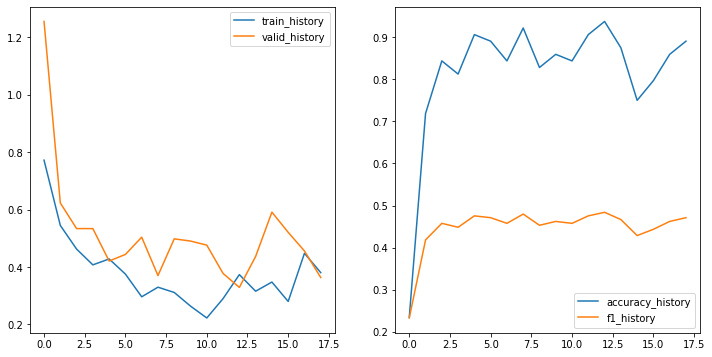

training finished


In [ ]:
model = Model2().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-5, lr=1e-4)

patience = 250
num_batches = 1000

random_batch_training(model, trainset, validset, criterion, optimizer, num_batches, patience)

In [ ]:
testing(model, testset, best_model_path='best_model_by_rand_batch.pt')

{'accuracy': 0.8663194444444444, 'f1_score': 0.5765969604907828}

И accuracy, и f1-score при обучении модели без весов получились выше, чем на предыдущем разбиении. Однако, стоит иметь в виду, что классы там были более-менее сбалансированы, а во всех проведённых экспериментах при уравновешивании классов (посредством разбиения или весов в лоссе) значения метрик были более низкими.

accuracy_score:0.59375
f1_score:0.4975845410628019
i 700, valid 0.7414071559906006
_________


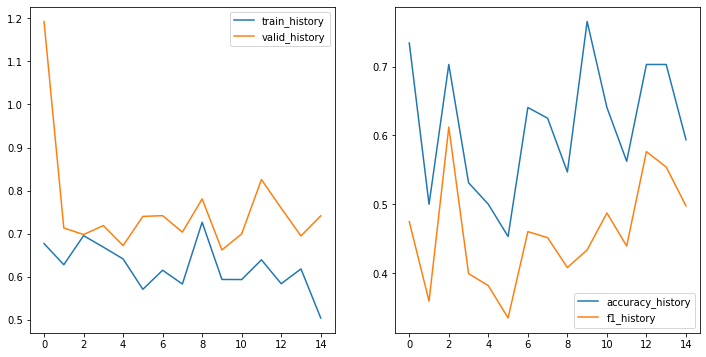

training finished


In [ ]:
model = Model2().to(device)

weight = class_weight.compute_class_weight('balanced', np.unique(train[1]), train[1])
weight = weight / sum(weight)
weight = torch.tensor(weight, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight)

optimizer = Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-5, lr=1e-4)

patience = 250
num_batches = 1000

random_batch_training(model, trainset, validset, criterion, optimizer, num_batches, patience)

In [ ]:
testing(model, testset, best_model_path='best_model_by_rand_batch.pt')

{'accuracy': 0.6886574074074073, 'f1_score': 0.47212201856409075}

В данном случае, ожидаемо, и accuracy, и f1-score упали, однако следует отметить, что accuracy получилась здесь больше, чем при предыдущем (сбалансированном) разбиении, в то время как f1-score немного упала. Однако, вновь-таки, результаты получаются низкие.

## Вывод

По результатам проведённых экспериментов с архитектурами моделей и разбиениями на классы, можно заключить, что обучить модели для адекватного распознавания возраста человека по его голосу не удалось. При дисбалансе классов accuracy, как правило, стремилась к доле доминирующего класса в тренировочной выборке, величина f1-score при этом всегда получалась заметно меньше. Для сбалансированных (посредством разбиения или применения весов при обучении) классов разрыв между accuracy и f1-score снижался, хотя оба показателя при этом уменьшались. Что любопытно, для сбалансированных классов значения обеих метрик оставались примерно одинаковыми независимо от модели (было показано на примере трёх классов) или границ разбиения, меняясь только при изменении *числа* классов, и при этом f1-score колебалась около $\Large{\frac{1}{число \ классов}}$. Принимая во внимание данные факты, предположу, что модели просто в большинстве случаев предсказывали один и тот же класс, не выучивая никаких конкретных закономерностей, и исправить ситуацию не помогли ни изменение архитектуры, ни сдвиги границ классов. 

Возможно, существуют приёмы, которые оказались бы в данном случае более эффективными — например, какие-то особые структуры моделей, подходы к обучению или обработке данных. Тем не менее, даже если такие методы существуют, мне кажется, что определение возраста человека по его голосу является довольно сложной задачей. Исходя из жизненного опыта, я не могу сказать, что голос человека может заметно измениться именно в силу определённых возрастных причин (не беря в расчёт изменения в подростковом периоде), но при этом на него могут повлиять, например, условия жизни, особенности работы и другие факторы. Кроме того, спектрограммы голосов мужчин и женщин явно отличаются, т.е. хорошая модель должна быть способна определять верный возраст для людей разного пола. Также определённую роль может сыграть интонация, манера речи говорящего или эмоции, с которыми произносится тот или иной текст. Конечно, разделить говорящих на категории вроде "ребёнок"-"взрослый человек"-"пожилой человек" может быть достаточно легко, однако сделать более точные предсказания мне кажется затруднительным. В представленном датасете же (который был относительно небольшим) голоса в большинстве записей принадлежали людям в возрасте 25-35 лет, т.е. находящимся в одной возрастной категории. Помимо этого, записи голосов были довольно короткими, а матрицы мел-спектрограмм — разреженными, что также могло усложнить задачу. На мой взгляд, перечисленные выше факторы могли стать наиболее вероятными причинами неудовлетворительных результатов.

Если же существуют хорошие классификаторы возраста и их можно успешно обучить, то, думаю, они могли бы пригодиться для повышения качества работы различных голосовых помощников — например, при составлении определённых рекомендаций для пользователя (фильмов, музыки и др.). Также можно было бы применять данные модели для определения возраста пользователя в интернете с целью фильтрации неприемлемого для детей контента. Другой вариант — использование подобных моделей для того, чтобы обучать "синтезаторы речи" генерировать речь человека определённой возрастной категории — по принципу дискриминативных моделей в GAN'ах, например. 